In [309]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

In [310]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The code for this notebook is hidden for easier reading.
To toggle it on/off, please click <a href="javascript:code_toggle()">here</a>.''')

# Cleaning & Feature Engineering

**Dataset: [Wine Reviews Scraped From WineEnthusiast The Week of June 15th, 2017](https://www.kaggle.com/zynicide/wine-reviews)**

**Disclaimer:** I chose this dataset at random. I also focused on building single-feature models (to simplify comparison) and understanding how characteristics of the underlying data impacted both models' performance. Optimization was not my priority. 

**Feature:** *'Price'* - Continuous - Rescaled to [0,1].
**Target:** *'Points'* - Continuous - Rescaled to [0,1].

In [311]:
path = 'C:\\Users\\missn\\Documents\\Thinkful\\CSV Datasets\\Unit 3\\Least Squares & KNN Regression\\wine.csv'
wine = pd.read_csv(path)
wine = wine[['points','price']]
wine = wine.astype('float64')
wine = wine.dropna()
min_max_scaler = preprocessing.MinMaxScaler()
wine.points = min_max_scaler.fit_transform(wine.points.values.reshape(-1,1))
wine.price = min_max_scaler.fit_transform(wine.price.values.reshape(-1,1))
wine.head()

,points,price
0,0.80,0.100610
1,0.80,0.046167
2,0.80,0.037456
3,0.80,0.026568
4,0.75,0.027003


In [312]:
wine.describe()

,points,price
count,137235.000000,137235.000000
mean,0.389396,0.012688
std,0.161084,0.015820
min,0.000000,0.000000
25%,0.300000,0.005226
50%,0.400000,0.008711
75%,0.500000,0.015679
max,1.000000,1.000000


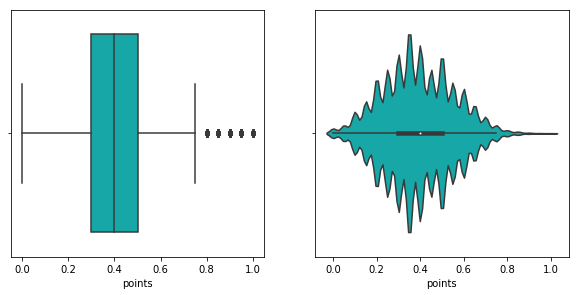

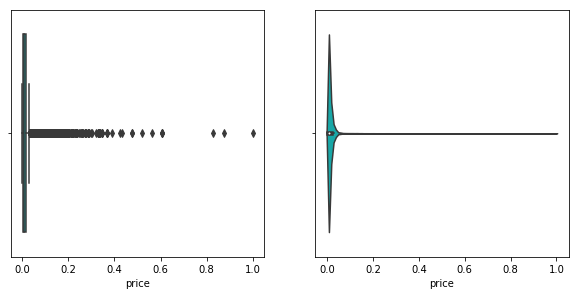

In [313]:
plt.figure(figsize=(10,10))
plt.subplot(221)
points = sns.boxplot(wine.points, color='c')
plt.subplot(222)
points = sns.violinplot(wine.points, color ='c')
plt.figure(figsize=(10,10))
plt.subplot(223)
points = sns.boxplot(wine.price, color='c')
plt.subplot(224)
points = sns.violinplot(wine.price, color='c')

## TOGGLE: Uncomment To Remove Outliers From Feature & Target

In [314]:
# columns = list(wine[['points','price']].columns)
# for column in columns: 
#     q25 = wine[column].quantile(0.25)
#     q75 = wine[column].quantile(0.75)
#     iqr = q75 - q25
#     maximum = q75 + (iqr * 1.5)
#     wine=wine.where(wine[column] < maximum)

In [315]:
# plt.figure(figsize=(10,10))
# plt.subplot(221)
# points = sns.boxplot(wine.points, color='c')
# plt.subplot(222)
# points = sns.violinplot(wine.points, color ='c')
# plt.figure(figsize=(10,10))
# plt.subplot(223)
# points = sns.boxplot(wine.price, color='c')
# plt.subplot(224)
# points = sns.violinplot(wine.price, color='c')

In [316]:
# def clean_dataset(df):
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)
# wine = clean_dataset(wine)

# Linear Regression Model

In [317]:
Y = pd.DataFrame(wine.points)
X = pd.DataFrame(wine.price)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [318]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [[4.71713852]]

Intercept: 
 [0.32965778]

R-Squared:
0.21151623063515712


In [319]:
score = cross_val_score(regr, X, Y, cv=5)
print("Cross-Validated Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross-Validated Accuracy: 0.19 (+/- 0.09)


In [320]:
wine_train = pd.concat([X_train, Y_train], axis=1)
lf = 'points ~ price'
lm = smf.ols(formula=lf, data=wine_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                 1.841e+04
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        09:03:27   Log-Likelihood:                 36065.
No. Observations:               68617   AIC:                        -7.213e+04
Df Residuals:                   68615   BIC:                        -7.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3297      0.001    470.200      0.0

## Checking Assumptions

### Linearity

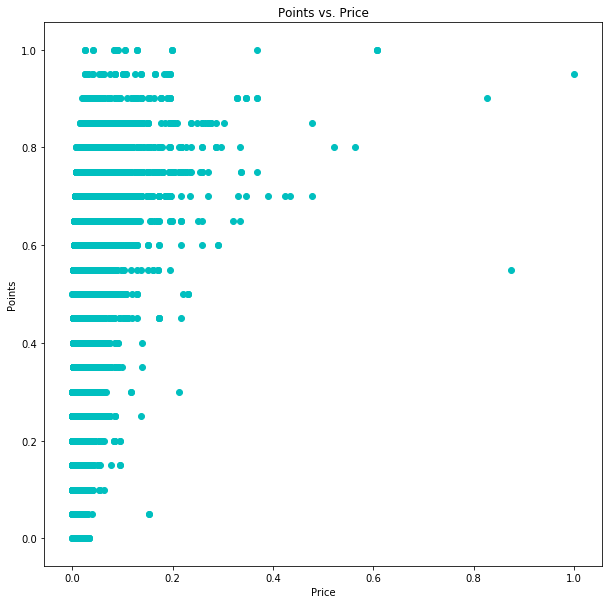

In [321]:
plt.figure(figsize=(10,10))
plt.scatter(y=wine.points, x=wine.price, color='c')
plt.ylabel('Points')
plt.xlabel('Price')
plt.title('Points vs. Price')
plt.show()

### Normality

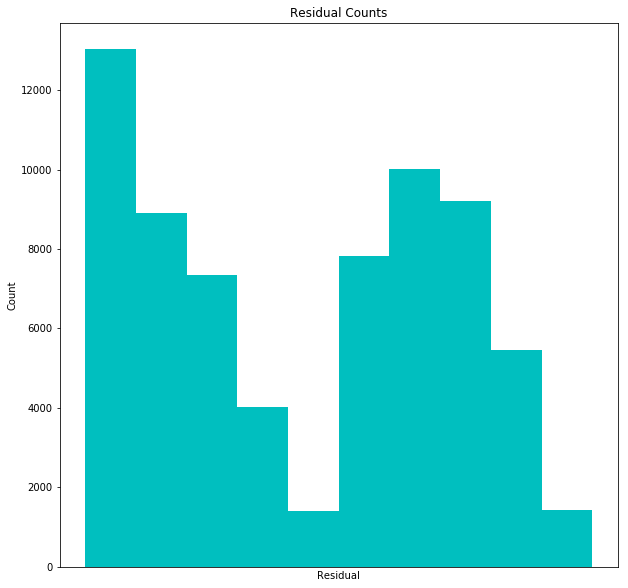

In [322]:
predicted = regr.predict(X_train)
actual = Y_train
residual = actual - predicted

plt.figure(figsize=(10,10))
plt.hist(residual, color = 'c')
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.ylabel('Count')
plt.show()

### Homodscedasticity

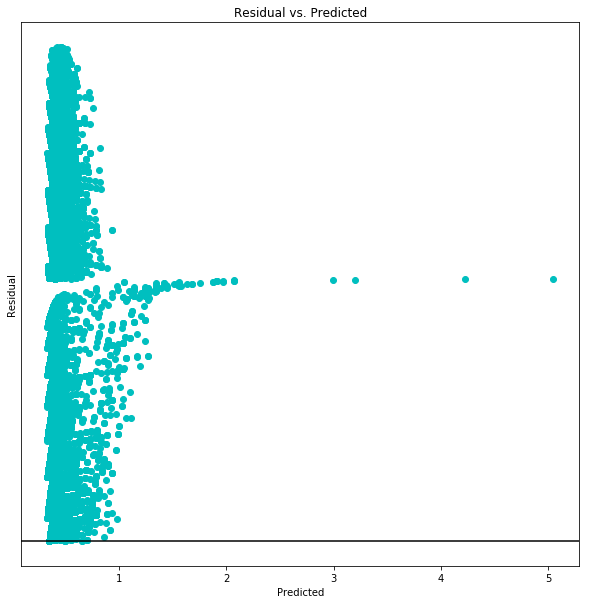

In [323]:
plt.figure(figsize=(10,10))
plt.scatter(predicted, residual, color = 'c')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.yticks([])
plt.axhline(y=0, color = 'k')
plt.title('Residual vs. Predicted')
plt.show()

### Correlation

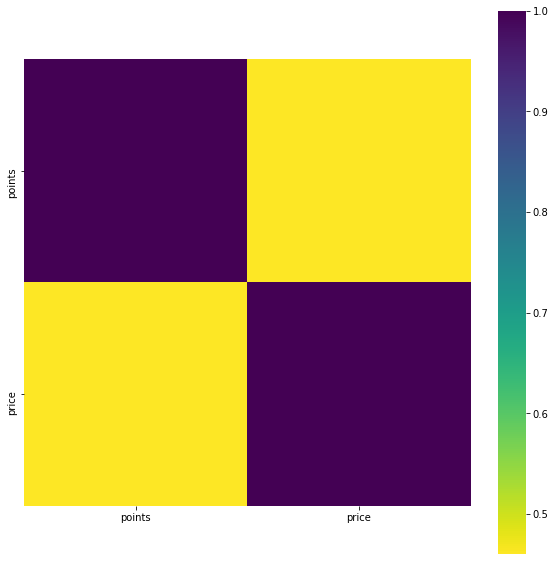

In [324]:
plt.figure(figsize=(10,10))
correlation_matrix = wine.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap='viridis_r',square = True)

# KNN Regression Models: Weighted & Unweighted 

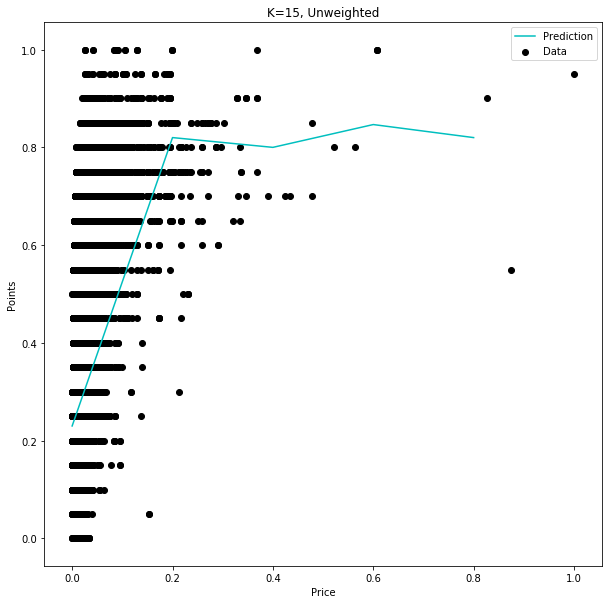

Unweighted Accuracy: 0.32 (+/- 0.04)


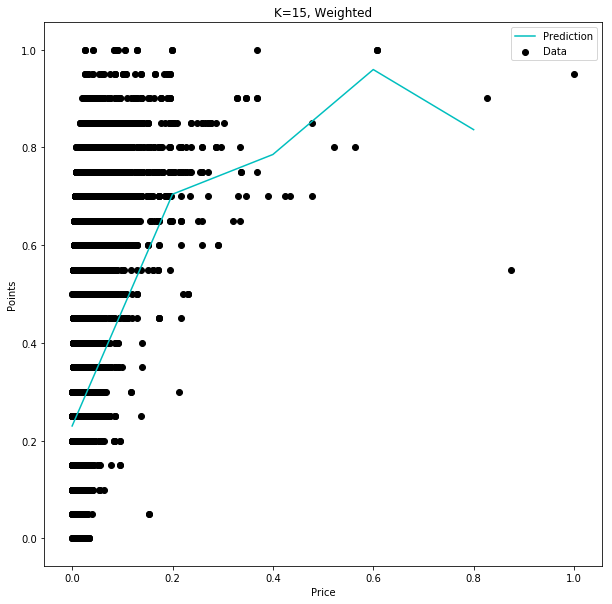

Weighted Accuracy: 0.32 (+/- 0.04)


In [325]:
#Unweighted KNN Regression.
knn = neighbors.KNeighborsRegressor(n_neighbors=15)
Y = wine.points.values.reshape(-1,1)
X = wine.price.values.reshape(-1,1)
knn.fit(X, Y)
T = np.arange(0, 1, .2)[:, np.newaxis]
Y_ = knn.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='c', label='Prediction')
plt.legend()
plt.ylabel('Points')
plt.xlabel('Price')
plt.title('K=15, Unweighted')
plt.show()

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

#Weighted KNN Regression.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=15, weights='distance')
knn_w.fit(X, Y)
T = np.arange(0, 1, .2)[:, np.newaxis]
Y_ = knn_w.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='c', label='Prediction')
plt.legend()
plt.ylabel('Points')
plt.xlabel('Price')
plt.title('K=15, Weighted')
plt.show()


score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Comparative Analysis

**Underlying Data Characteristics:** There are both price and point outliers - wines that are exorbitantly priced relative to others, and wines that are scored much higher than others. But the relationship between price and points is weakly linear - the price distribution for wines that are equally scored, and conversely the points distribution for wines that are equally prices, are both wide.   

**Model Comparison:** Before outliers are eliminated, the KNN Regression Models ( both UnWeighted and Weighted) perform better than the Linear Regression Model. Once the outliers are eliminated, the Linear Regression Model performs better than the KNN Regression Models. My decision to scale both the feature and the target might have neutralized the impact of weighting. 